Note: This is a work in progress. I am changing things constantly.

## 1 Intro

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

### 1.1 Objective/Initial Question

In this report, I aim to complete the analysis of what sorts of people were likely to survive. I plan to apply the tools of machine learning to predict which passengers were more likely to survive the tragedy.

## 2 Obtain the data

### 2.1 Import Libraries

In [1]:
# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

### 2.2 Setup Helper Functions

In [2]:
def plot_hist(var):
    plt.hist(var)
    plt.xlabel(str(var.name))
    plt.ylabel('Frequency')
    plt.title('The frequency distribution of ' + str(var.name).lower())

def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) 
        # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    #facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.set( xlim=( 0 , 150 ) )
    facet.add_legend()
    facet.set_axis_labels(var, 'Probability Density')

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
        
    
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))

### 2.3 Load data

Note: I retrospectively set the index column after reviewing the dataframe in the next section. I briefly checked that all the PassengerId values were unique to ensure it made sense to have it as an index column.

In [3]:
df = pd.read_csv('titanic_data.csv', index_col='PassengerId')
train = pd.read_csv('train.csv', index_col='PassengerId')
test = pd.read_csv('test.csv', index_col='PassengerId')

#full = train.append(test, ignore_index= True, sort=False)
#titanic = full[:891]

#print("Dataset Shapes - Full: {}, Titanic: {} ".format(full.shape, titanic.shape))

Now, let's look at the data set we are working with. But before I do, I'll past the variable definitions provided by Kaggle that came with the  data set.

#### Variable definitions

- Survival:	Survival	(0 = No, 1 = Yes)
- Pclass: Ticket class	(1 = 1st, 2 = 2nd, 3 = 3rd)
- Sex: Sex	
- Age: Age in years	
- Sibsp: # of siblings / spouses aboard the Titanic	
- Parch: # of parents / children aboard the Titanic	
- Ticket: Ticket number	
- Fare:	Passenger fare	
- Cabin: Cabin number	
- Embarked:	Port of Embarkation	(C = Cherbourg, Q = Queenstown, S = Southampton)

Now let's look at the data!

In [4]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Having seen the data, i'm documenting questions I have at this stage which may lead to interesting results. Of course as I learn more about the data, this is likely to change. However below is what I have listed as a starting point.

#### Potentially Interesting Questions

- Are women and children more likely to have survived? (Why: The movies portray women and children to be given priority) 
- Are those who are over sixty less likely to have survived? (Why: Declining health)
- Are those who paid less for their ticket/or bought a lower class ticket more likely to have survived? (Why: "Harder life assumption")
- How many complete families survived (i.e. where people had siblings/spouses/parches/children and I am able to locate their families through last name.
- Where families didn't survive, what kind of member didn't?
- Are people with significantly discounted tickets more likely to survive?
- Were there any discounts given to elderly/young people?
- Did men or women pay more on average for their ticket?
- Were certain ages of men/women more likely to travel alone?
- Were lone travellers more likely to survive?

What's the shape of the data?

In [5]:
df.shape

(891, 11)

We have 891 rows and 12 columns. 

What data types are we dealing with?

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


Reviwing the dataframe table, table info and table summary above, I am going to start listing a few potential issues which may need cleansing.
- Incomplete data for the "Age", "Cabin" and "Embarked" columns. 
- I can also see that we have several columns which have been loaded as an object. I may need to convert these to a string later.
- Some of the name fields have two names with one bracketed (potentially someone buying a ticket on the behalf of someone else).

#### Fixing problems in the data

I know that the data has missing values for Age. Therefore I am going to take the mean age and set the remaining values to this.

In [7]:
df['Age'] = df['Age'].fillna(df['Age'].mean())

print(df['Age'].mean())

29.69911764705882


All the blank age values have been populated with 29.699118.

We are missing two values for embarked which I am happy to ignore for now. As for cabin, there are only 204/891 values provided. At this point, I don't know what analysis I plan to do with the cabin field so I will leave it as-is for now.

## 3 Exploring the data

### 3.1 Statistical summaries and visualisations

I'll use the describe function of pandas to give me a few summary statistics for our quanitative variables. Hopefully this should give me an idea of what factors could play an important role in whether a person would have survived or not. Remember 0 is a non-survivor and 1 is a survivor.

In [48]:
df.groupby('Survived').describe().T

Survived               0           1
Age    count  549.000000  342.000000
       mean    30.415100   28.549778
       std     12.457370   13.772498
       min      1.000000    0.420000
       25%     23.000000   21.000000
       50%     29.699118   29.699118
       75%     35.000000   35.000000
       max     74.000000   80.000000
Fare   count  549.000000  342.000000
       mean    22.117887   48.395408
       std     31.388207   66.596998
       min      0.000000    0.000000
       25%      7.854200   12.475000
       50%     10.500000   26.000000
       75%     26.000000   57.000000
       max    263.000000  512.329200
Parch  count  549.000000  342.000000
       mean     0.329690    0.464912
       std      0.823166    0.771712
       min      0.000000    0.000000
       25%      0.000000    0.000000
       50%      0.000000    0.000000
       75%      0.000000    1.000000
       max      6.000000    5.000000
Pclass count  549.000000  342.000000
       mean     2.531876    1.950292
       std      0.735805    0.863321
       min      1.000000    1.000000
       25%      2.000000    1.000000
       50%      3.000000    2.000000
       75%      3.000000    3.000000
       max      3.000000    3.000000
SibSp  count  549.000000  342.000000
       mean     0.553734    0.473684
       std      1.288399    0.708688
       min      0.000000    0.000000
       25%      0.000000    0.000000
       50%      0.000000    0.000000
       75%      1.000000    1.000000
       max      8.000000    4.000000

It's interesting to see that for the Fare variable, both the mean and the median (50%) are significantly higher for survivors. The inverse relationship can be observed for Pclass. Thinking about this logically, Pclass is the ticket class of which there are three options, 1st, 2nd and 3rd class (represented as 1, 2 and 3 respectively). Given this, you would expect that as the Pclass increases (from 1 to 3), that the associated Fare would decrease - i.e. an inverser relationship. 

### 3.2 A heat map of correlation 

The below is a heat map of the strength of correlation (Pearson's r) of the variables we have available. This should hopefully give me more of an indication of which variables are strongly correlated - paying particular attention to survival.

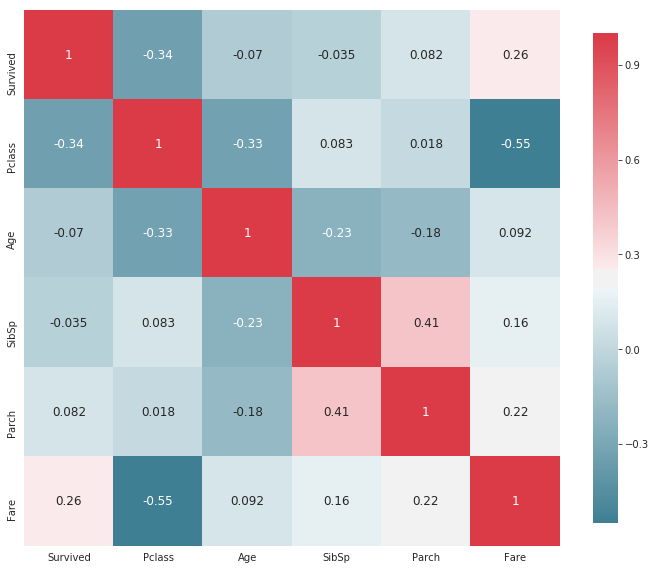

In [9]:
plot_correlation_map(df)

The correlation heatmap shows us that there are some relationships that may lead to interesting insights by further investigation.

**Relationships that appear to impact survival**
- PClass and Survived (-0.34) 
- Fare and Survived (0.26)

Pclass is negatively correlated with survival - i.e. those with a higher class ticket (represented by a lower number) were more likely to have survive. Previously we theorised that Pclass and Fare would be negatively correlated which we can see to be true (correlation of -0.55). Therefore it is not suprising to see that the inverse relationship for Pclass can be seen with Fare. Those who payed more for their ticket is positively correlated with the amount of survivors. 

_Could preferential treatment possibly have been given to those with a higher class ticket? Could bribery have played a hand? Or could the upper class be better at getting what they want?_

**Other correlations of note**
- Parch and SibSp (0.41)
- Age and SibSp (-0.31)
- Age and PClass (-0.37)
- Parch and Age (-0.19)
- Parch and SibSp (0.41)



### 3.3 Pairwise plots

The pair plot below shows pairwise relationships in the data set. This gives a quick idea of what variables drive separation and is a useful tool for taking further for machine learning algorithms.

- Where plotting pairwise variables that are non-identical, produces a scatter plot 
- Where plotting pairwise variables that are identical - a kernal density estimation plot is produced (similar to a histogram)

Note some points appear a strong red or strong blue despite setting the alpha (transparency) of all points to 0.3. This phenomena can be explained by several data points having the same values (common with discrete variables). This makes sense - one person with four siblings aboard will result in four other people with four siblings aboard.

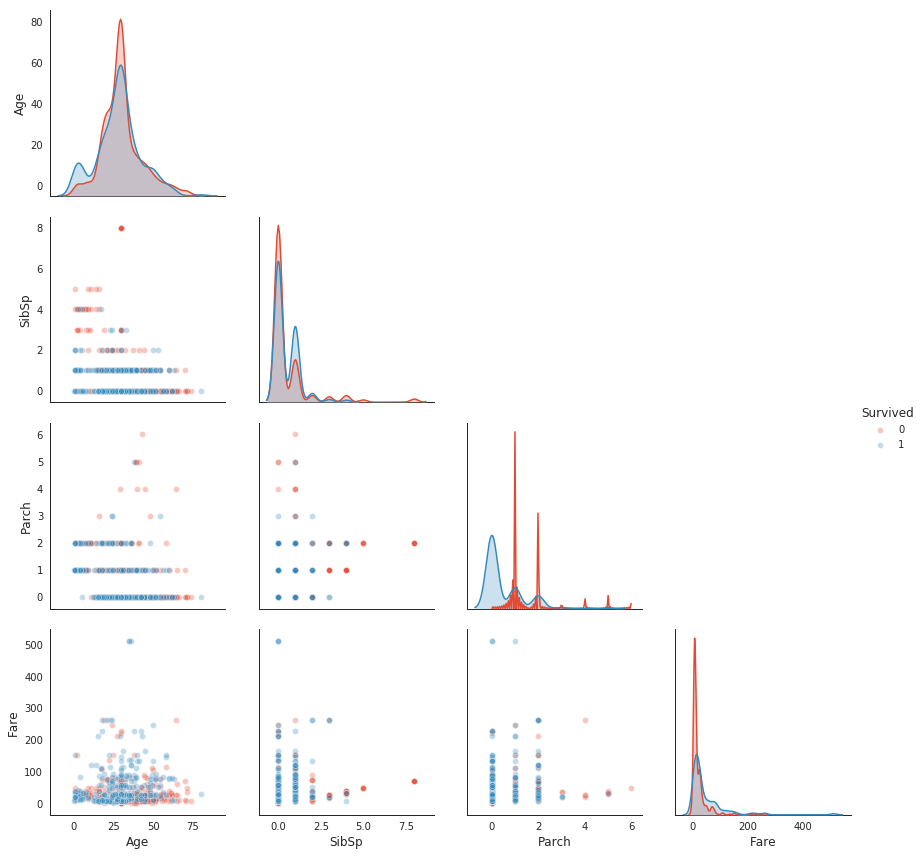

In [10]:
#This produces a number of plots with variables paired up. This should hopefully give me an indication of how easy
# it will be to decide whether a person would have survived or not based on the data we have available to us.
pair_plot = sns.pairplot(df,
            hue= 'Survived', # The target, the variable we are trying to see separation for.
            vars= ['Age', 'SibSp','Parch', 'Fare'], # The variables we are working with
            height=3, #size of each plot
            diag_kind='kde', #Kind of plot for the diagonal subplots
            plot_kws=dict(alpha=0.3))

#The below code hides the top right triangle of plots (which is a mirror of the bottom left)
for i, j in zip(*np.triu_indices_from(pair_plot.axes, 1)):
    pair_plot.axes[i, j].set_visible(False)

It doesn't appear like we can conclusively say that one variable acts as a clear differentiator as to whether a person would have survived or not. However, there appears to be enough separation to achieve some sort of conclusion by combining variables (features in a machine learning algorithm). 

**Those with a low Parch (# of parents / children aboard) and/or a low SibSp (# of siblings / spouses) appear to have a higher chance of survival than those with a high Parch.** 


Density plots (**X-Y**)
- **Age-Age, SibSp-SibSp** and **Fare-Fare** look inconclusive, the plots appear to show a similar shape for both survival outcomes).
- **Parch-Parch** shows quite clear separation between survivors and non-survivors with the former being linked to a zero parch.

Scatter Plots (**X-Y**)
- **Age-SibSp** appears to show a particularly strong concentration of non-survivors in the top left (corresponding to young people with many siblings.
- **Age-Parch**, **SibSp-Parch** show that a low Parch increases chance of survival.
- **SibSp-Parch** appears that those with a low amount of siblings and parents/children aboard had a higher chance of survival (the bottom left of the graph is very blue). 
- **Age-Fare** appears inconclusive.


**Potential justifcation**

These trends don't sound suprising. Potential justification could be that parents/children would spend more time collecting their families. Another potentital justification (imagine queuing for a theme park ride) could be that families were to big to fit on lifeboats together, and that smaller travellers were called forward in the queue. If this were true, we would expect a similar relationship for the SibSp variable.

### 3.4 Looking further into areas of interest

Going forward there are a few main areas I want to further investigate that I feel could lead to an interesting story. In this section we will delve deeper into some of the interesting relationships identified with the high level plots and statistical summaries.

- The relationships between age/sex and survival
- The relationships between class/ticket price and survival
- The relationships between number of parents/children/spouses/siblings aboard and survival

#### The relationship between age/sex and survival

Here I am going to form three distinct groups which I will use to see if there is a story worth telling here. I'll group the data into children (Age < 18) and men and women. I also may form a fourth group of people over age sixty.

In [56]:
for index, row in df.iterrows():

    x = row['Age']

    if x < 18:
        group = 'Child'
    elif x > 60:
        group = 'Senior'
    elif row.Sex == 'male':
        group = 'Adult Man'
    elif row.Sex == 'female':
        group = 'Adult Woman'

    df.loc[index, 'Age/Sex Grouping'] = group
    
age_sex_groups = df.groupby('Age/Sex Grouping')
age_sex_groups.mean()

,Survived,Pclass,Age,SibSp,Parch,Fare
Age/Sex Grouping,,,,,,
Adult Man,0.168000,2.388000,31.647381,0.294000,0.136000,24.519523
Adult Woman,0.750000,2.093750,31.890833,0.589844,0.574219,46.859653
Child,0.539823,2.584071,9.041327,1.460177,1.053097,31.220798
Senior,0.227273,1.590909,66.022727,0.136364,0.272727,41.371214


With means significantly above the overall mean for survival (0.38), it appears that if you were a woman (0.75) or child (0.54), your chances of survival appear to be significantly higher. The mean for an adult woman is 4.5x higher than an adult man.


As we know that there were limited lifeboats on the titanic, this would make sense. To prove/disprove this, I will look at performing statistical tests in the conclusion part of this report.



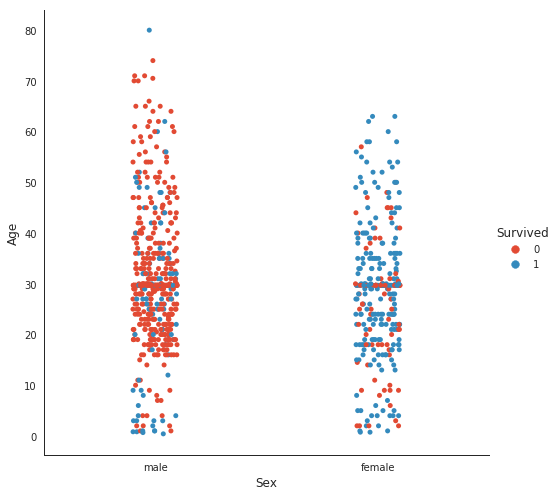

In [99]:
sns.catplot(height=7, aspect=1, x="Sex", y="Age", data=df, hue="Survived")

- Clearly women were more likely to survive than men (it looks fairly even across all ages)
- Young boys were more likely to survive than adult men

#### The relationship between ticket fare/class and survival

Carrying on with the groupings established earlier in this study (based on age/sex), here we will analyse how the two variable 'Pclass' and 'Fare' are related to 'Survived'.

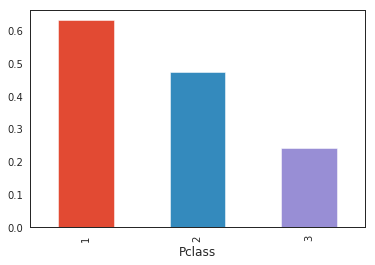

In [60]:
class_groups = df.groupby('Pclass')
survived_class_groups = class_groups['Survived'].mean()
survived_class_groups.plot.bar()

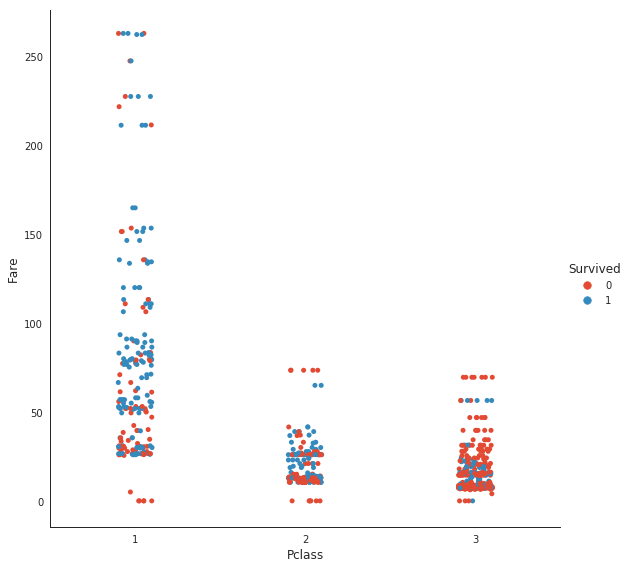

In [113]:
sns.catplot(height=8, aspect=1, x="Pclass", y="Fare", data=df[df['Fare']<300], hue="Survived")

#### The relationships between number of parents/children/spouses/siblings aboard and survival

I wonder if new features could be engineered e.g. 
- lone traveller/couple/family from Sibsp/Parch & Last Name.
- discounted ticket from an incongruent Pclass and Fare.
- Family role - i.e. mother, father, brother, sister, spouse (might be able to infer spouse from the bracketed name)

### Can we  tell anything from the families?

In [ ]:
import re

#Duplicating the table as I know we may have to deal with bracketed families later:
fam_df = df
def name_splitter(name_array):
#name_ex = 'Futrelle, Mrs. Jacques Heath (Lily May Peel)'

    split_name = re.findall('(?<=\()[\w\s]+(?=\))|\w+', name_array)

    # splits last name and title from other names
    last_name = split_name[0]
    title = split_name[1]
    other_names = split_name[2:]

    return split_name


In [ ]:

def new_name_columns(df):
    """Creates two new columns for names"""
    split_names  = df['Name'].apply(name_splitter)
    df['Last Name'] = split_names.apply(lambda x:x[0])
    df['Title'] = split_names.apply(lambda x:x[1])

    return None

new_name_columns(df)

In [ ]:
df.head()

In [ ]:
family_groups = df.groupby('Last Name')
family_groups.iloc['Sage'].mean()

In [ ]:
sibsp_grouping = df.groupby('SibSp')
sibsp_grouping['Survived'].describe()

In [ ]:
sibsp_grouping.get_group(5)

In [ ]:
sibsp_grouping.get_group(8)

We can see we don't have ages for any of the Sage family so they have automatically been averaged out at 29.6.

In [ ]:
sibsp_grouping.get_group(4)

Initial thoughts:
- It appears to be better for chances of survival to have 1 or 2 siblings/spouses on board than 0.
- 

## 4 Draw Conclusions

Here I will use either statistics or machine learning to really confirm what the data is telling us and answer the primary question

As we are dealing with discrete data for age/sex groupings and whether a person survived or not. I have opted to use the Chi-squared test. In order to do this hypothesis test I need to understand how many people survived in each cataegory.

We know from earlier that the mean survival rate is 0.38.

### Statistical tests

#### Chi-squared test for age/sex groupings

Below I state our null and alternative hypothesis. I aim to test at the 95% confidence level.

- H0: The proportion of survivors is the same in each of our four age/sex groupings.
- Ha: The proportion of survivors is not the same in each of our four age/sex groupings.

Calculating observed survivors - I do this by summing up the survived column for our grouping made on age_sex earlier (as 1= survivor and 0=non-survivor, we are essentially counting cells where Survived=1 within each group).

In [ ]:
observed_survivors = age_sex_groups.Survived.sum()
print(observed_survivors)

Calculating expected survivors - I do this by taking the overall proportion of survivors and multiplying by the count of each age/sex group. I then perform a test to ensure the value we calculated for survivors above is the same as below.

In [ ]:
survivor_grouping = df.groupby('Survived')['Survived'].count()
print(survivor_grouping)
print('Test: ' + str(survivor_grouping.iloc[1] == observed_survivors.sum()))

total_asg = age_sex_groups.Name.count() #Count for each group
total_survivors = survivor_grouping[1]
expected_survivors = (total_survivors/survivor_grouping.sum())*total_asg
print(' \nExpected Survivors: \n')
print(expected_survivors)

In [ ]:
age_sex_df = pd.DataFrame({
    'Observed Survivors': observed_survivors,
    'Expected Survivors': expected_survivors,
    },
    index=['Adult Man', 'Adult Woman', 'Child', 'Senior'])

age_sex_df

Calculating chi-squared with 3 degrees of freedom.

In [ ]:
from scipy.stats import chisquare

chi_squared = 0
for index, record in age_sex_df.iterrows():
    obs = record['Observed Survivors']
    exp = record['Expected Survivors']
    value = ((obs-exp)**2)/exp
    
    chi_squared += value
    
print('The chi_squared value is: ' + str(chi_squared))

#Testing with equation
chisquare(f_obs = observed_survivors, f_exp = expected_survivors, ddof=3, axis =0)

# Ignore for now / Ignore for now / Ignore for now / Ignore for now 

In [ ]:
df[(df.Pclass == 1) & (df.Fare < 20) ]

#### Age and Survived

Male and Female grouping

In [ ]:


sex_group = df.groupby('Sex')
male_group = sex_group.get_group('male')
female_group = sex_group.get_group('female')

x = male_group.iloc[1:100]
#print(x['Age'])


#plt.hist(male_group['Survived'])


#sex_group.plot(x='Age', y='Survived')
#plt.scatter(sex_group['Age'], sex_group['Survived'])

In [ ]:
from math import ceil, floor

def create_range(df, var, base):
    """Takes a variable and returns the variable in a range - useful for producing histograms
    df = dataframe for function to act on
    var = the variable you would like to convert into a range (string)
    base = the upper and lower bounds of the range
    
    """

    for index, row in df.iterrows():

        x = row[var]
        lower = int(base * floor(float(x)/base))
        if x % base != 0:
            upper = int(base * ceil(float(x)/base))
        else:
            upper = lower + base

        df.loc[index, '{}_range'.format(var)] = '{} - {}'.format(lower, upper)
    
    return df



In [ ]:
create_range(df, 'Age', 10)

#del df['Age_range']
    
df.head()

I'm quite a visual person. I don't immediately see any interesting insights from looking at this statistical summary. To aid this i'm going to plot the distributions.

In [ ]:
plot_hist(df.Age)

In [ ]:
plot_hist(df.SibSp)

In [ ]:
plot_hist(df.Parch)

In [ ]:
plot_hist(df.Fare)

The distribution appears to highlight outliers (as high as 500). This leads me to go a step further and calculate the median. As we can below, it is significantly different from the mean.

In [ ]:
print(df['Fare'].median())